# **ML Flow**

In [77]:
import mlflow
from dotenv import load_dotenv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import seaborn as sns
import joblib

import os
import platform

from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LinearRegression 
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error

# **Introduction**

It Help in the machine learning workflow. As a Python package, it can be easily installed using `pip install mlflow`. MLflow is composed of four main modules:

- **Tracking**:  allows you to log and query experiments, including code versions, parameters, metrics, and output files, ensuring you can reproduce and compare results across different runs.

- **Projects**: provides a standard format for packaging reusable data science code. It enables you to organize your code in a way that makes it easy to run and reproduce across different environments.

- **Models**: MLflow Models offers a unified approach for packaging machine learning models. It supports multiple formats (e.g., TensorFlow, PyTorch, Scikit-Learn) 

- **Registry**: The Model Registry provides a centralized place to manage and govern the full lifecycle of your models. It includes functionalities for versioning, staging, and annotating models, helping maintain an organized workflow from experimentation to production.




## **Tracking experiments**

MLflow traking module allows to organize the experiments into runs, and keep track of the :

- **Parameters**:  path to train dataset, number of epochs, learning rate, etc.

- **metrics**: accuracy, loss, etc.

- **metadata**: code version, git commit, etc.

- **artifcats**: any file produced during the run, such as model, plots, etc.

- **models**: the model itself, which can be saved and loaded using the MLflow API.

Creating a new experiment by using `.set_experiment()` method: 

In [79]:
# Load .env 
load_dotenv()

# Determine the operating system
is_linux = platform.system() == 'Linux'
is_windows = platform.system() == 'Windows'

if is_linux:
    root_url = os.path.expanduser(os.getenv("ROOT_URL_LINUX"))
elif is_windows:
    root_url = os.getenv("ROOT_URL_WINDOWS")
else:
    raise EnvironmentError("Unsupported operating system")

# Construct paths for MLflow tracking
mlflow_tracking_uri = str(Path(root_url) / 'mlops-zoomcamp/01-mlflow-tracking/mlruns')

os.environ["MLFLOW_TRACKING_URI"] = mlflow_tracking_uri
experiment_name = os.getenv("MLFLOW_EXPERIMENT_NAME")

print(f"MLFLOW_EXPERIMENT_NAME set to: {experiment_name}")
print(f"MLFLOW_TRACKING_URI set to: {mlflow_tracking_uri}")

mlflow.set_tracking_uri(mlflow_tracking_uri)
mlflow.set_experiment(experiment_name)


2024/09/19 20:29:35 INFO mlflow.tracking.fluent: Experiment with name 'taxi-trip' does not exist. Creating a new experiment.


MLFLOW_EXPERIMENT_NAME set to: taxi-trip
MLFLOW_TRACKING_URI set to: /home/marcos/GitHub/mlops-zoomcamp/01-mlflow-tracking/mlruns


<Experiment: artifact_location='/home/marcos/GitHub/mlops-zoomcamp/01-mlflow-tracking/mlruns/666102029943634674', creation_time=1726788575104, experiment_id='666102029943634674', last_update_time=1726788575104, lifecycle_stage='active', name='taxi-trip', tags={}>

## Preprocessing Taxi Data

In [80]:
def preprocess_trip_data(file_path, min_duration=1, max_duration=60):

    df = pd.read_parquet(file_path)

    df.lpep_pickup_datetime = pd.to_datetime(df.lpep_pickup_datetime)
    df.lpep_dropoff_datetime = pd.to_datetime(df.lpep_dropoff_datetime)


    df['trip_duration'] = (df.lpep_dropoff_datetime - df.lpep_pickup_datetime).dt.seconds/60

    # subset the data between min_duration and max_duration
    df = df[(df['trip_duration'] >= min_duration) & (df['trip_duration'] <= max_duration)].copy()

    categorical = ['PULocationID', 'DOLocationID']
    df[categorical] = df[categorical].astype(str)
    df['PU_DO']  = df['PULocationID'] + '_' + df['DOLocationID']
    

    return df


df_train = preprocess_trip_data('data/raw/green/2023/01/green_tripdata_2023_01.parquet')
df_val = preprocess_trip_data('data/raw/green/2023/02/green_tripdata_2023_02.parquet')
len(df_train), len(df_val)

(65946, 62574)

In [81]:
categorical = ['PU_DO'] #'PULocationID', 'DOLocationID']
numerical = ['trip_distance']

dv = DictVectorizer()

train_dicts = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dicts)

val_dicts = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dicts)

y_train = df_train['trip_duration'].values
y_val = df_val['trip_duration'].values

## Trining and Saving Model

In [82]:
lr = LinearRegression()
lr.fit(X_train, y_train)

y_pred = lr.predict(X_val)

rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"RMSE: {rmse}")

RMSE: 6.037558422778642


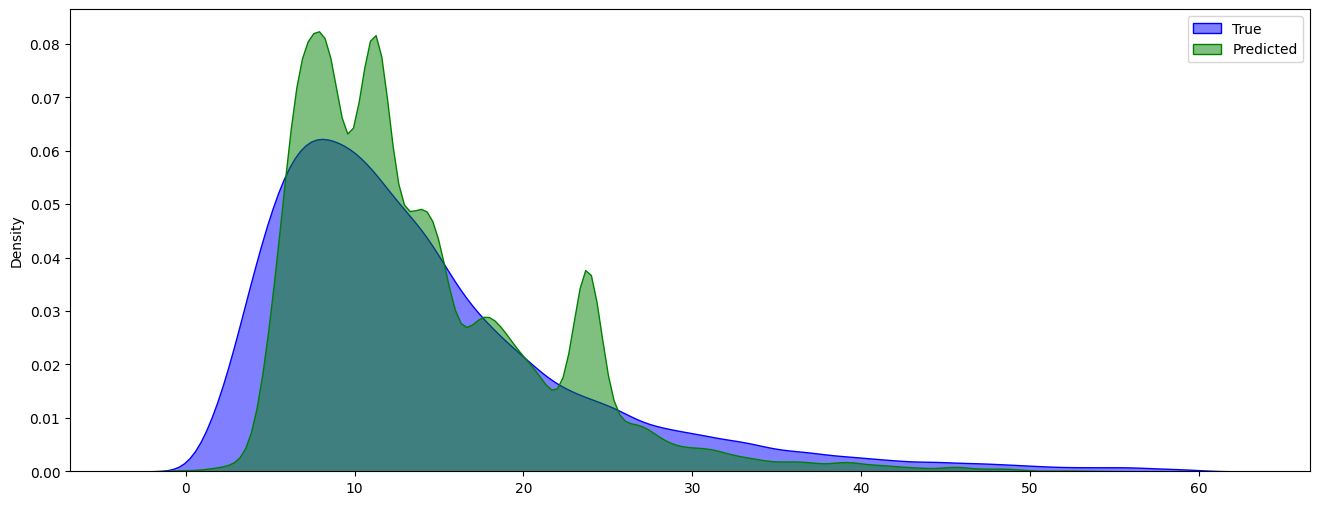

In [83]:
plt.figure(figsize=(16, 6))

# KDE plot for residuals
sns.kdeplot(y_val, color='blue', fill=True, alpha=0.5, label='True')
sns.kdeplot(y_pred, color='green', fill=True, alpha=0.5, label='Predicted')
plt.legend()


In [84]:
# Save trained model
os.makedirs('models', exist_ok=True)
model_filename = 'models/lr_model.joblib'

with open('models/lin_reg.joblib', 'wb') as f_out:
    joblib.dump((dv, lr), f_out)

print(f"Model saved to: {model_filename}")


Model saved to: models/lr_model.joblib


## MLflow Structure

**Experiment:** An experiment is a container for multiple runs. It has a unique experiment ID that groups together all the runs related to a specific experiment or goal. We can think of an experiment as a folder that holds many runs. Each experiment can be used to track a different set of experiments, such as hyperparameter tuning or model comparison.

**Run:** A run represents a single execution or trial within an experiment. Each run has a unique run ID, and it logs parameters, metrics, artifacts, and other information associated with that specific run.
A run is essentially a child of an experiment, and multiple runs can belong to the same experiment. Runs allow you to track different configurations or experiments, like different hyperparameters or models, under the same experiment.

**Parameters:** Parameters are variables that can be logged and associated with a run. They are typically used to track hyperparameters or other input values that influence the outcome of the run. For example, the learning rate or the number of epochs are common parameters that can be logged.


In MLflow, a run is a single instance of an experiment where we train a model, log parameters, metrics, and artifacts. However, to try different configurations or models under the same overall goal or experiment we can use nested runs. Nested runs are runs that are created within another run, allowing us to group related runs together. This can be useful when we want to compare different models or hyperparameters under the same experiment. The structure for the nested runs are the following:


```
Experiment (experiment_id: 123)
│
├── Run 1 (run_id: abc123)
│   ├── parameters: alpha=0.01
│   ├── metrics: rmse=0.85
│   ├── artifacts: lasso_model_alpha_0.01.joblib
│   ├── tags
│
├── Run 2 (run_id: def456)
│   ├── parameters: alpha=0.1
│   ├── metrics: rmse=0.78
│   ├── artifacts: lasso_model_alpha_0.1.joblib
│   ├── tags
│
├── Run 3 (run_id: ghi789)
│   ├── parameters: alpha=0.2
│   ├── metrics: rmse=0.81
│   ├── artifacts: lasso_model_alpha_0.2.joblib
│   ├── tags
```
<center><img src="figures/mlflow_folder_structure.png" width="800" height="800"></center>

**Usefull Commands**

1. **Tags** (`.set_tag`):
   - Used to categorize and label runs, making them easier to find and organize in the MLflow UI.

2. **Logging Parameters** (`.log_param`):
   - Tracks hyperparameters like **alpha** and important metadata such as dataset paths, making it possible to recreate or analyze the run's conditions.

3. **Logging Metrics** (`.log_metric`):
   - Tracks the performance of the model, such as **RMSE**, providing a quantifiable metric that can be compared across different runs or experiments.

4. **Logging Artifacts** (`.log_artifact`):
   - Saves important files (like trained models) as artifacts, ensuring that they are available for future use or deployment.

In [85]:
with mlflow.start_run(run_name="Parent Experiment"):
    # Log the general experiment information
    mlflow.set_tag("experiment_type", "Hyperparameter tuning")
    mlflow.log_param("train-data-path", "data/raw/green/2023/01/green_tripdata_2023_01.parquet")
    mlflow.log_param("valid-data-path", "data/raw/green/2023/02/green_tripdata_2023_02.parquet")
    
    for alpha in [0.001, 0.01, 0.1, 0.2, 0.4]:
        # Start a nested run for each alpha value
        run_name = f"Lasso model with alpha={alpha}"
        with mlflow.start_run(nested=True, run_name= run_name):
            mlflow.log_param("alpha", alpha)
            
            # Train the model
            lr = Lasso(alpha)
            lr.fit(X_train, y_train)
            
            # Log performance metrics
            y_pred = lr.predict(X_val)
            rmse = mean_squared_error(y_val, y_pred, squared=False)
            mlflow.log_metric("rmse", rmse)
            
            # Save trained model
            os.makedirs('models', exist_ok=True)
            model_filename = f'models/lasso_model_alpha_{alpha}.joblib'

            with open(model_filename, 'wb') as f_out:
                joblib.dump((dv, lr), f_out)

            print(f"Model saved to: {model_filename}")

            # Log the model artifact
            mlflow.log_artifact(local_path=model_filename, artifact_path="models")
            
    mlflow.end_run()

Model saved to: models/lasso_model_alpha_0.001.joblib
Model saved to: models/lasso_model_alpha_0.01.joblib
Model saved to: models/lasso_model_alpha_0.1.joblib
Model saved to: models/lasso_model_alpha_0.2.joblib
Model saved to: models/lasso_model_alpha_0.4.joblib




<center><img src="figures/mlflow_experiment_ui.png"></center>

# Exemplo Using XGBoost

In [60]:
import xgboost as xgb
import optuna